In [1]:
# coding: utf-8
# In[2]:

get_ipython().run_line_magic('pylab', 'inline')

import configparser
import os, glob, sys, time, datetime
import pandas as pd
import pandas.io.sql as pdsql
from pandas import DataFrame, Series
import math
import numpy as np
from numpy import NaN, Inf, arange, isscalar, asarray, array
import scipy as sp
from scipy import stats
from scipy.stats import norm

import talib as ta
from talib import MA_Type

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager

import seaborn as sns

from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()

from zigzag import *

#맑은고딕체
sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [12, 8]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=10)

config = configparser.ConfigParser()
config.read('config/config.ini')

MySQL_POOL_SIZE = int(config['MYSQL']['MySQL_POOL_SIZE'])
user = config['MYSQL']['USER']
passw = config['MYSQL']['PASSW']
host = config['MYSQL']['HOST']
port = int(config['MYSQL']['PORT'])
database = config['MYSQL']['DATABASE']

def mysqlconn():    
    conn = pymysql.connect(host=host, port=port, user=user, passwd=passw, db=database, charset='utf8mb4', use_unicode=True)
    return conn



def comma_volume(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}K'.format(int(x/1000))
    return s

def comma_price(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}'.format(int(x))
    return s

def comma_percent(x, pos):  # formatter function takes tick label and tick position
    s = '{:+.2f}'.format(x)
    return s

major_date_formatter = mdates.DateFormatter('%Y-%m-%d')
minor_date_formatter = mdates.DateFormatter('%m')
price_formatter = ticker.FuncFormatter(comma_price)
volume_formatter = ticker.FuncFormatter(comma_volume)
percent_formatter = ticker.FuncFormatter(comma_percent)



from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, XGBModel
from xgboost import plot_importance, plot_tree

Populating the interactive namespace from numpy and matplotlib


In [6]:
def get_price(code, 시작일자=None, 종료일자=None, 테이블='data_daily_binance'):
    if 시작일자 is None and 종료일자 is None:
        query = """
            SELECT date,open,high,low,close,volume
            FROM {}
            WHERE symbol='{}'
            ORDER BY date ASC
            """.format(테이블, code)
    if 시작일자 is not None and 종료일자 is None:
        query = """
            SELECT date,open,high,low,close,volume
            FROM {}
            WHERE symbol='{}' AND date >= '{}'
            ORDER BY date ASC
            """.format(테이블, code, 시작일자)
    if 시작일자 is None and 종료일자 is not None:
        query = """
            SELECT date,open,high,low,close,volume
            FROM {}
            WHERE symbol='{}' AND date <= '{}'
            ORDER BY date ASC
            """.format(테이블, code, 종료일자)
    if 시작일자 is not None and 종료일자 is not None:
        query = """
            SELECT date,open,high,low,close,volume
            FROM {}
            WHERE symbol='{}' AND date BETWEEN '{}' AND '{}'
            ORDER BY date ASC
            """.format(테이블, code, 시작일자, 종료일자)

    conn = mysqlconn()
    df = pdsql.read_sql_query(query, con=conn)
    conn.close()
    return df

def XGBoost_Feature(model, df, X_columns, y_columns, performCV=True, printFeatureImportance=True, cv_folds=5):
    print(model)

    model.fit(df[X_columns], df[y_columns])
        
    df_predictions = model.predict(df[X_columns])
    
    try:
        df_predprob = model.predict_proba(df[X_columns])[:,1]
    except Exception as e:
        pass

    print ("\n<< 모델 보고서 >>")
    try:
        print (" - 정확도(Accuracy) : %.4g" % metrics.accuracy_score(df[y_columns].values, df_predictions))
    except Exception as e:
        pass

    try:
        print (" - AUC 점수 (Train): %f" % metrics.roc_auc_score(df[y_columns].values, df_predprob))
    except Exception as e:
        pass

    # cross_validation 은 sklearn.model_selection.train_test_split 으로 대체됨.
    # cv_score = cross_validation.cross_val_score(model, df[X_columns], df[y_columns], cv=cv_folds, scoring='roc_auc')
    if performCV:
        try:
            cv_score = cross_val_score(model, df[X_columns], df[y_columns], cv=cv_folds, scoring='roc_auc')
            print (" [교차검증(CV) 점수] 평균 : %.7g | 표준편차 : %.7g | 최소값 : %.7g | 최대값 : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        except Exception as e:
            pass
        
    try:
        if printFeatureImportance:
            fig, ax = plt.subplots(1, 1, sharex=True)
            feat_imp = pd.Series(model.feature_importances_, X_columns).sort_values(ascending=False)
            feat_imp.plot(ax=ax, kind='bar', title='특성(Feature) 중요도')
            ax.yaxis.set_major_formatter(percent_formatter)
            plt.ylabel('특성(Feature) 중요도 점수')
            plt.savefig('특성(Feature) 중요도.png')
            plt.show()
    except Exception as e:
        pass

def XGBoost_TuningTest(model, X, y, param_grid=None):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

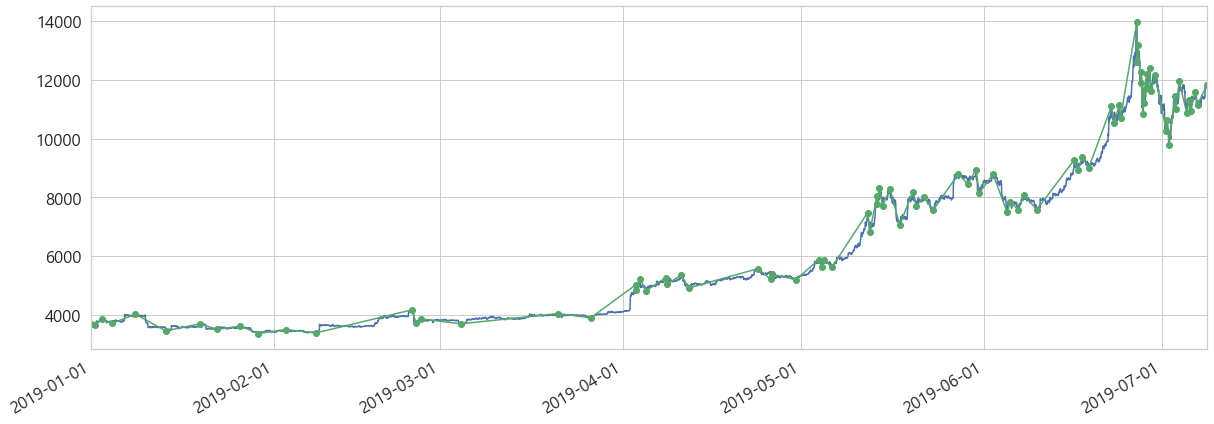

In [7]:
# ---
# * 모멘텀과 주가 위치를 활용 *
symbol = "BTC/USDT"
# close = DataFrame(get_price(symbol, 시작일자='2019-03-01', 테이블='data_hourly_binance'))
df = DataFrame(get_price(symbol, 시작일자='2019-01-01', 테이블='data_hourly_binance'))

# * ZigZag 응용 *
# zigzag 항목 추가
def convZigzag(p):    
    # from zigzag import *
    p = p.set_index(p['date'].values)
    p['date'] = pd.to_datetime(p['date'], errors='coerce').apply(lambda x:x.strftime('%Y%m%d'))
    pivots = peak_valley_pivots(p['close'].values, 0.03, -0.03)
    fig = plt.figure(constrained_layout=False,figsize=(20,7))
    gs = GridSpec(1, 1, figure=fig)
    ax1 = fig.add_subplot(gs[0])
    
    ts_pivots = pd.Series(p['close'], index=p.index)
    ts_pivots = ts_pivots[pivots != 0]
    
    p['date'] = p.index.map(mdates.date2num)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.plot(p.index, p['close'])
    ts_pivots.plot(style='g-o')
    return pivots

df['ZigZag'] = convZigzag(df)
df['TREND'] = df['ZigZag'].replace(to_replace=0, method='ffill')

In [8]:
X_COLUMNS = []

#for i in [2,3,5,10,20,40,60,90,120,240]:
for i in [20,40,90,120,240]:
    df['EMA%03d' % i] = ta.EMA(np.array(df['close']), timeperiod=i)
    df['이격도 %03d' % i] = (df['close'] - df['EMA%03d' % i]) / df['EMA%03d' % i]
    X_COLUMNS.append('이격도 %03d' % i)

# 볼린저 밴드
# for i in [20, 60, 240]:
#     df['Bup'], df['Bctr'], df['Bdown'] = ta.BBANDS(np.array(df['close']), timeperiod=i, nbdevup=2.0, nbdevdn=2.0, matype=ta.MA_Type.EMA)
#     df['pB %03d' % i] = (df['close'] - df['Bdown']) / (df['Bup'] - df['Bdown'])
#     X_COLUMNS.append('pB %03d' % i)

# RSI
for i in [5,7,10,14]:
    df['RSI %02d' % i] = ta.RSI(np.array(df['close']), timeperiod=i) / 100
    X_COLUMNS.append('RSI %02d' % i)

# MFI
for i in [10,14,18]:
    df['MFI %02d' % i] = ta.MFI(np.array(df['high']),np.array(df['low']),np.array(df['close']),np.array(df['volume']),timeperiod=i) / 100
    X_COLUMNS.append('MFI %02d' % i)

# OBV
# df['OBV'] = ta.OBV(np.array(df['close']),np.array(df['volume'])) / 100
# X_COLUMNS.append('OBV')

# ADX
for i in [10,12,14,18,22]:
    df['ADX %02d' % i] = ta.ADX(np.array(df['high']),np.array(df['low']),np.array(df['close']),timeperiod=i) / 100
    X_COLUMNS.append('ADX %02d' % i)

# 모멘텀 : MOM
for i in [10,12,14,18,22]:
    df['MOM %d' % i] = ta.MOM(np.array(df['close']),timeperiod=i) / 100
    X_COLUMNS.append('MOM %d' % i)
    
# 모멘텀
#for i in range(1,6):
for i in [2,3,4]:
    df['모멘텀 %d' % i] = (df['close']-df['close'].shift(i)) / df['close'].shift(i)
    X_COLUMNS.append('모멘텀 %d' % i)

# 박스 추세
#for i in range(1,6):
for i in [2,3,5]:
    df['박스추세 %d' % i] = (df['close'] - df['close'].rolling(window=5).min().shift(i)) / (df['close'].rolling(window=5).max().shift(i) - df['close'].rolling(window=5).min().shift(i))
    X_COLUMNS.append('박스추세 %d' % i)


df['y'] = df['TREND']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df[X_COLUMNS].values.tolist()
y = df['y'].values.tolist()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

<< 모델 보고서 >>
 - 정확도(Accuracy) : 0.864
 - AUC 점수 (Train): 0.920273
 [교차검증(CV) 점수] 평균 : 0.7133476 | 표준편차 : 0.05392485 | 최소값 : 0.6099888 | 최대값 : 0.7578557


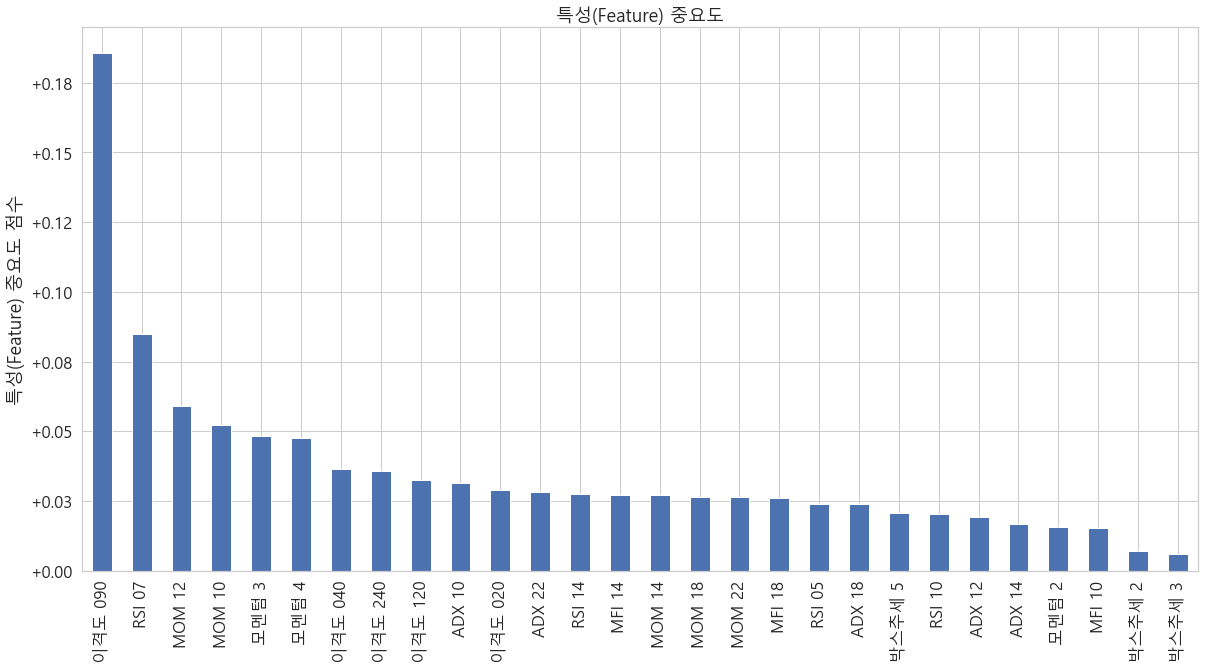

In [9]:
default_params = {'random_state': 0}
model = XGBClassifier(**default_params)

matplotlib.rcParams['figure.figsize'] = [20, 10]
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)

In [143]:
param_grid = {
    'max_depth': range(1, 4, 1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], 
    'n_estimators': range(10, 50, 10),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'colsample_bylevel':[0.8, 1.0]
}

XGBoost_TuningTest(model, X=np.array(X), y=np.array(y), param_grid=param_grid)

KeyboardInterrupt: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bytree=1.0, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=40, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1.0)

<< 모델 보고서 >>
 - 정확도(Accuracy) : 0.8254
 - AUC 점수 (Train): 0.883481
 [교차검증(CV) 점수] 평균 : 0.7338948 | 표준편차 : 0.04652477 | 최소값 : 0.6437097 | 최대값 : 0.7729188


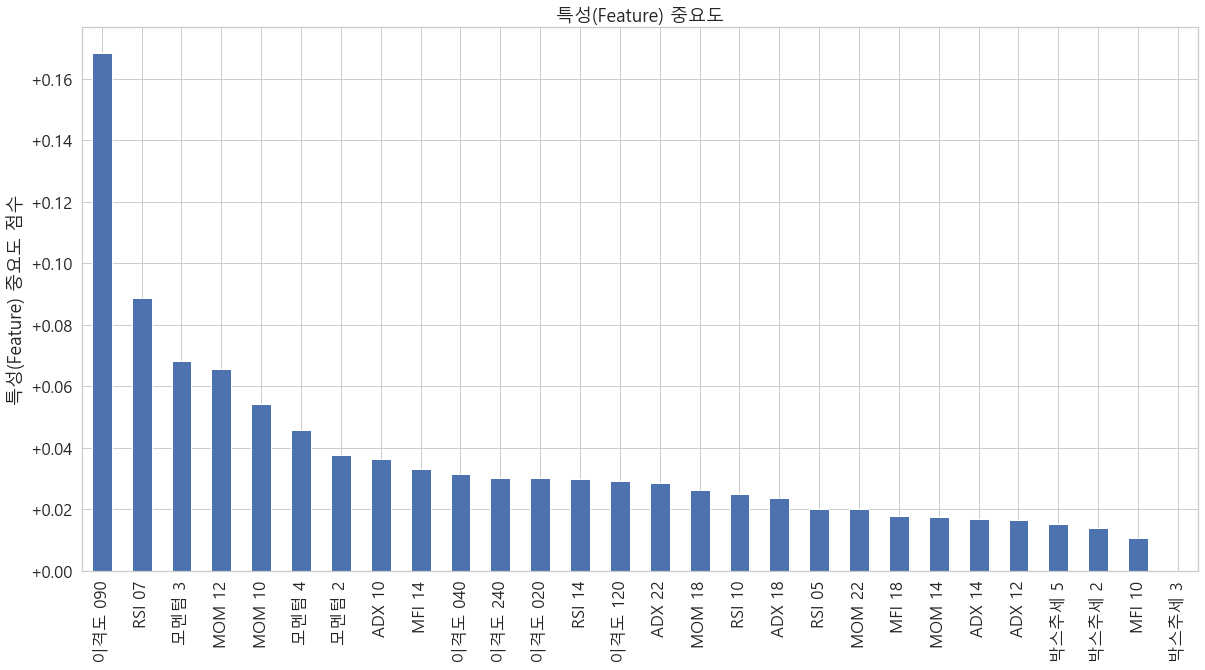

In [10]:
tuned_params = {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40, 'subsample': 1.0, 'random_state': 0}
model = XGBClassifier(**tuned_params)

# matplotlib.rcParams['figure.figsize'] = [20, 10]
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)